In [11]:
from dotenv import load_dotenv
agentssdotenv()

agentsslangchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI
from langgraph.graph import StateGraph, END, START
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.runnables.graph_mermaid import MermaidDrawMethod
from IPython.display import Image, display

from agent.schemas import AgentState
from configs.settings import settings
from agent.prompts import system_prompt

In [12]:
def should_continue(state: AgentState) -> str:
    last = state["messages"][-1]
    if isinstance(last, AIMessage) and getattr(last, "tool_calls", None):
        return "tools"
    return END

def add_user_message(state: AgentState, user_text: str) -> AgentState:
    state["messages"].append(HumanMessage(content=user_text))
    return state

In [13]:
llm = ChatGoogleGenerativeAI(
        model=settings.MODEL,
        api_key=settings.GEMINI_API_KEY,
        temperature=0.2,
    )
llm = llm.bind_tools([])

E0000 00:00:1758812294.448295   11877 alts_credentials.cc:93] ALTS creds ignored. Not running on GCP and untrusted ALTS is not enabled.


In [21]:
def call_model(state: AgentState) -> AgentState:
    messages = state["messages"]
    response = llm.invoke([SystemMessage(content=system_prompt)] + messages)
    state["messages"].append(response)
    return state

graph = StateGraph(AgentState)
graph.add_node("Agent-B", call_model)
graph.add_node("tools", ToolNode([]))

graph.add_edge(START, "Agent-B")
graph.add_conditional_edges(
    "Agent-B",
    tools_condition,
)
graph.add_edge("tools", "Agent-B")

graph = graph.compile()

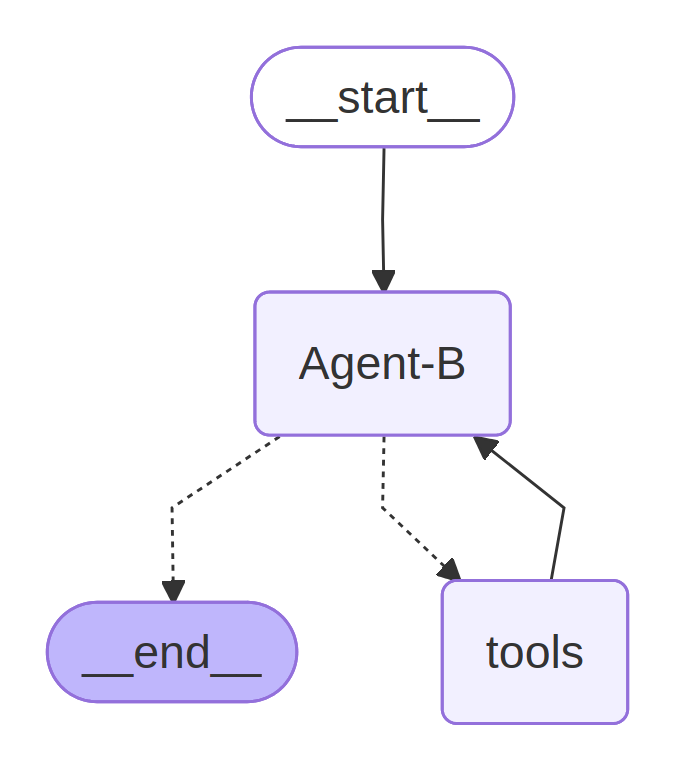

In [23]:
import nest_asyncio
nest_asyncio.apply()

display(Image(graph.get_graph().draw_mermaid_png(draw_method=MermaidDrawMethod.PYPPETEER)))